In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import talib

import quandl
API='ev8wgXS3LGQgZuHp6Bvm'
quandl.ApiConfig.api_key = API

from sklearn.linear_model import ElasticNet

from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization,Bidirectional
from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [2]:
stock=quandl.get('WIKI/MSFT',start_date="2010-01-01")

<AxesSubplot:xlabel='Date'>

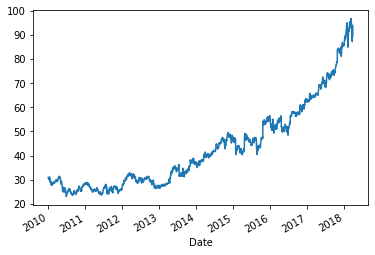

In [3]:
stock["Close"].plot()

In [37]:
def Get_sequence_data(data,lookback=10,future=1): 
    X_seq_data=[]
    Y_seq_data=[]
    for i in range(lookback,len(data)-future+1,lookback):
        X_seq_data.append(data.iloc[i-lookback:i,:])
        Y_seq_data.append(data["Close"].iloc[i-lookback+future:i+future])
        #Y_seq_data.append(data["Close"].iloc[i])
    
    return np.asarray(X_seq_data),np.asfarray(Y_seq_data)

def Prepare_dataset(dataset,data_limit=300,test=0.2,seq=True,lookback=10,scale=True,tech_ind=False):
    global scaler
    
    dataset=dataset.dropna(how="all")
    dataset=dataset.iloc[:data_limit,:]
    dataset=dataset.iloc[:,0:5]
    
    if tech_ind==True:
        # Create 7 and 21 days Moving Average
        dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
        dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
        
        # Create MACD
        dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
        dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
        dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

        # Create Bollinger Bands
        dataset['20sd'] = dataset["Close"].rolling(20).std()
        dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
        dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
        
        # Create Exponential moving average
        dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
        
        # Create Momentum
        dataset['momentum'] = dataset['Close']-1
        
        dataset['RSI']=talib.RSI(dataset['Close'],14)
        dataset=dataset.iloc[25:-1]
    
    t=int(len(dataset)*(1-test))
    
    train=dataset.iloc[:t,:]
    test=dataset.iloc[t:,:]   
    
    if scale==True:
        scaler=MinMaxScaler()
        scaler=scaler.fit(train['Close'].values.reshape(-1,1))
        train.loc[:,'Close']=scaler.transform(train['Close'].values.reshape(-1,1))
        test.loc[:,'Close']=scaler.transform(test['Close'].values.reshape(-1,1))

    if seq==True:
        seq_tr=Get_sequence_data(train,lb)
        seq_te=Get_sequence_data(test,lb)
        
        X_train=seq_tr[0]
        y_train=seq_tr[1]
        X_test=seq_te[0]
        y_test=seq_te[1]
    else:
        X_train=train.drop('Close',axis=1)
        y_train=train['Close'].shift(-1)
        X_test=test.drop('Close',axis=1)
        y_test=test['Close'].shift(-1)
        
        X_train=np.asarray(X_train).reshape(1,X_train.shape[0],X_train.shape[1])
        y_train=train['Close'].shift(-1).values.reshape(1,-1)
        X_test=np.asarray(X_test).reshape(1,X_test.shape[0],X_test.shape[1])
        y_test=test['Close'].shift(-1).values.reshape(1,-1)
        
    
    return X_train,X_test,y_train,y_test
    
   #return train, \
   #         test, \
    #        np.asarray(train['Close'].shift(-1)), \
    #        np.asarray(test['Close'].shift(-1))
def LSTM_model():
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(units=100, dropout=0.8, recurrent_dropout=0.2,return_sequences=True,
                input_shape = (lb,rnn_X_train.shape[2])))

    model.add(LSTM(units=50, dropout=0.8,return_sequences=False, recurrent_dropout=0.2))
    model.add(Dense(1,activation='linear'))
    return model

In [46]:
lb=25
X_train,X_test,y_train,y_test=Prepare_dataset(stock,data_limit=5000,seq=True,lookback=lb,scale=False)

rnn_X_train=tf.convert_to_tensor(X_train.astype('float'))
rnn_y_train=tf.convert_to_tensor(y_train.astype('float'))

rnn_X_test=tf.convert_to_tensor(X_test.astype('float'))
rnn_y_test=tf.convert_to_tensor(y_test.astype('float'))

In [47]:
rnn_X_train.shape,rnn_X_test.shape,rnn_y_train.shape,rnn_y_test.shape

(TensorShape([66, 25, 5]),
 TensorShape([16, 25, 5]),
 TensorShape([66, 25]),
 TensorShape([16, 25]))

In [48]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units=100, dropout=0.8, recurrent_dropout=0.2,return_sequences=True,
               input_shape = (lb,rnn_X_train.shape[2])))

model.add(LSTM(units=50, dropout=0.8,return_sequences=False, recurrent_dropout=0.2))
###
# model.add(Bidirectional(LSTM(units=10,return_sequences=True,input_shape = (lb,rnn_X_train.shape[2]))))
# model.add(Dropout(0.8))
# model.add(Bidirectional(LSTM(units=5,return_sequences=False)))
# model.add(Dropout(0.8))
###
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(units=50))
# model.add(Dropout(0.5))
model.add(Dense(1,activation='linear'))

defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mae',metrics=defined_metrics)

# Train the model
history=model.fit(rnn_X_train,rnn_y_train , epochs=30, batch_size=2,
                  shuffle=False,
                  validation_split=0.1,
                  callbacks=[callback])

Epoch 1/30
30/30 [==============================] - 7s 50ms/step - loss: 27.9610 - MSE: 799.0439 - val_loss: 47.3641 - val_MSE: 2247.3508
Epoch 2/30
30/30 [==============================] - 1s 32ms/step - loss: 22.4911 - MSE: 522.2372 - val_loss: 42.6282 - val_MSE: 1821.1537
Epoch 3/30
30/30 [==============================] - 1s 31ms/step - loss: 18.0601 - MSE: 346.1320 - val_loss: 39.9226 - val_MSE: 1597.8055
Epoch 4/30
30/30 [==============================] - 1s 31ms/step - loss: 15.6277 - MSE: 264.4534 - val_loss: 37.8702 - val_MSE: 1438.1377
Epoch 5/30
30/30 [==============================] - 1s 31ms/step - loss: 13.6278 - MSE: 206.1785 - val_loss: 35.9984 - val_MSE: 1299.8750
Epoch 6/30
30/30 [==============================] - 1s 34ms/step - loss: 11.7993 - MSE: 159.7460 - val_loss: 34.2083 - val_MSE: 1174.1986
Epoch 7/30
30/30 [==============================] - 1s 32ms/step - loss: 10.0036 - MSE: 120.7897 - val_loss: 32.4740 - val_MSE: 1058.5492
Epoch 8/30
30/30 [================

In [18]:
train_model=LSTM_model()

defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_model.compile(optimizer=optimizer, loss='mae',metrics=defined_metrics)

# Train the model
history=train_model.fit(rnn_X_train,rnn_y_train , epochs=30, batch_size=467,
                  shuffle=False,
                  validation_split=0.1,
                  callbacks=[callback])


Epoch 1/30
3/3 [==============================] - 17s 4s/step - loss: 29.8209 - MSE: 919.2804 - val_loss: 43.9180 - val_MSE: 1948.5475
Epoch 2/30
3/3 [==============================] - 12s 4s/step - loss: 24.5438 - MSE: 633.3142 - val_loss: 39.8729 - val_MSE: 1609.6027
Epoch 3/30
3/3 [==============================] - 12s 4s/step - loss: 20.6929 - MSE: 462.9353 - val_loss: 37.2656 - val_MSE: 1408.4800
Epoch 4/30
3/3 [==============================] - 13s 4s/step - loss: 18.4301 - MSE: 376.5489 - val_loss: 35.4151 - val_MSE: 1273.9850
Epoch 5/30
3/3 [==============================] - 13s 4s/step - loss: 16.7358 - MSE: 317.1661 - val_loss: 33.7306 - val_MSE: 1157.5070
Epoch 6/30
3/3 [==============================] - 13s 4s/step - loss: 15.0955 - MSE: 265.0026 - val_loss: 32.0870 - val_MSE: 1049.3280
Epoch 7/30
3/3 [==============================] - 14s 4s/step - loss: 13.4684 - MSE: 218.5181 - val_loss: 30.4478 - val_MSE: 946.8242
Epoch 8/30
3/3 [==============================] - 13s 4s

In [158]:
pred_model=LSTM_model(batch_size=40)
pred_model.set_weights(train_model.get_weights())

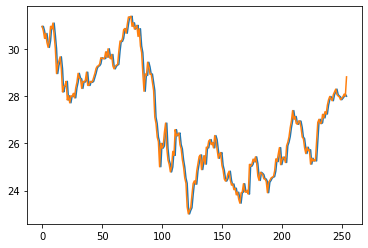

In [30]:
plt.plot(X_train[0,:,3],label='Traing')
plt.plot(y_train[0,:],label="Target")

ValueError: x and y can be no greater than 2-D, but have shapes (0,) and (0, 255, 12)

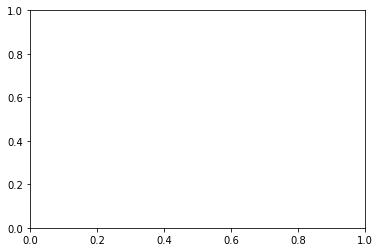

In [137]:
# Using predicted values to predict next step
X_pred = X_test.copy()
for i in range(lb,len(X_pred)):
    xin = X_pred[i,:,:].reshape((1, lb, 1))
    X_pred[i] = model.predict(xin)

# Plot prediction vs actual for test data
plt.figure()
plt.plot(X_pred[lb:],':',label='LSTM')
plt.plot(next_X1,'--',label='Actual')
plt.legend()

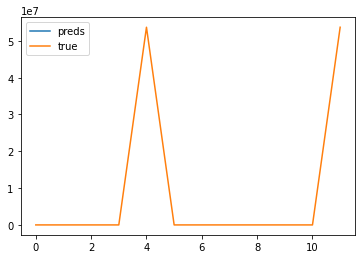

In [42]:
preds=model.predict(rnn_X_test)
plt.plot(preds,label='preds')
plt.plot(stock.iloc[-1,:].values,label='true')
plt.legend()
plt.show()

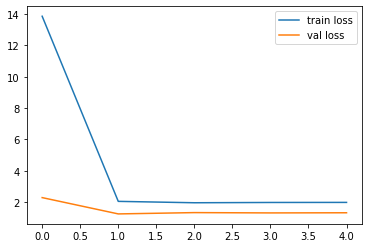

In [51]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.show()

In [52]:
score=model.evaluate(rnn_X_train,rnn_y_train)

7/7 [==============================] - 0s 4ms/step - loss: 2.2468 - MSE: 8.7670


In [115]:
score

[0.2859285771846771, 0.15177173912525177]

In [34]:
preds

array([[24.914175]], dtype=float32)

In [21]:
rnn_X_test.shape

(1, 1859, 23)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 22, 64)            19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 52,801
Trainable params: 52,801
Non-trainable params: 0
_________________________________________________________________


In [44]:
preds=model.predict(rnn_X_test)

In [45]:
preds

array([[4.4420824]], dtype=float32)